# QCNN demonstration with Noisy Devices

## 1. Load Noisemodel with IBMQ

Noise Model (Fake Provider)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import data
import embedding

n_qubits = 4

In [2]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.aer.backends import AerSimulator
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel

IBMQ.load_account()
noisy = FakeJakarta()

noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev_fake = qml.device(
    'qiskit.aer',
    wires=n_qubits,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Real device

In [3]:
TOKEN_tak = "798c4f141e8fa071c14823a956f816c8dda622f9f00b95cae62cc5b1a3105b4fe4845a234d661f20281f6b77ac0299e3c4367f6a3b58db16c36bcde3a9cb1151"
TOKEN_dkp = "3ae7ac10f40eb88c7ebb0eca20aa0788e7a96da729e2c3848d9864684362aaf50dfdda7cb3ec1ffd75eb7ed5b44f7c14f2f17419cf600ce14437ee7cd00ac75b"

IBMQ.save_account(token=TOKEN_dkp, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku')
backend = "ibmq_jakarta"

dev_jakarta = qml.device(
    'qiskit.ibmq',
    wires=4,
    shots=1024,
    backend=backend,
    provider=provider
)

ibmqfactory.load_account:WARNING:2023-01-15 03:11:30,832: Credentials are already in use. The existing account in the session will be replaced.


## 2. Feature Mapping Circuits

Create Feature Mapping Circuits. 

Note: This is 4 qubit feature mapping circuits used for demonstration.

Unlike noiseless simulation, last to first qubit CNOT gates are omitted for connectivity.

Also number of layers is set to 1 (N_layers = 3 for noiseless simulation).

In [3]:
def Noisy_Four_QuantumEmbedding1(input):
    for j in range(4):
        qml.Hadamard(wires=j)
        embedding.exp_Z(input[j], wires=j)
    for k in range(3):
        embedding.exp_ZZ2(input[k], input[k+1], wires=[k,k+1])
    #exp_ZZ2(input[3], input[0], wires=[3, 0])                  Removed for connectivity

def Noisy_Four_QuantumEmbedding1_inverse(input):
    #exp_ZZ2(input[3], input[0], wires=[3, 0], inverse=True)    Removce for connectivity
    for k in reversed(range(3)):
        embedding.exp_ZZ2(input[k], input[k+1], wires=[k,k+1], inverse=True)
        qml.Barrier()
    for j in range(4):
        embedding.exp_Z(input[j], wires=j, inverse=True)
        qml.Hadamard(wires=j)

# Quantum Embedding 2 for model 2
def Noisy_Four_QuantumEmbedding2(input):
    for j in range(4):
        qml.Hadamard(wires=j)
        embedding.exp_Z(input[j], wires=j)
    for k in range(3):
        embedding.exp_ZZ1(input[4+k], wires=[k, k+1])
    #exp_ZZ1(input[15], wires=[7,0])                        Removed for connectivity

def Noisy_Four_QuantumEmbedding2_inverse(input):
    #embedding.exp_ZZ1(input[15], wires=[7,0], inverse=True) Removed for connectivity
    for k in reversed(range(3)):
        embedding.exp_ZZ1(input[k+4], wires=[k,k+1], inverse=True)
    qml.Barrier()
    for j in range(4):
        embedding.exp_Z(input[j], wires=j, inverse=True)
        qml.Hadamard(wires=j)

Make Noisy Model1 and Model2 (Only fidelity loss is used)

In [4]:
import torch
from torch import nn

# Hybrid Model 1
@qml.qnode(dev_fake, interface="torch")
def circuit1(inputs): 
    Noisy_Four_QuantumEmbedding1(inputs[0:4])
    Noisy_Four_QuantumEmbedding1_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

class Noisy_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(circuit1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

# Hybrid Model 2
@qml.qnode(dev_fake, interface="torch")
def circuit2(inputs): 
    Noisy_Four_QuantumEmbedding2(inputs[0:7])
    Noisy_Four_QuantumEmbedding2_inverse(inputs[7:14])
    return qml.probs(wires=range(4))

class Noisy_Model2_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]

Draw the circuit and check if everything is right.

In [5]:
print("Circuit1: \n")
print(
    qml.draw(
        circuit1,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,1,2,3,4])
)

print("Circuit2: \n")
print(
    qml.draw(
        circuit2,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
)

Circuit1: 

0: ──H──RZ(-2.00)─╭●────────────╭●────────────────────────────────────────────────────────────
1: ──H──RZ(-4.00)─╰X──RZ(-4.89)─╰X─╭●────────────╭●──────────────────────────────────╭●───────
2: ──H──RZ(-6.00)──────────────────╰X──RZ(-0.32)─╰X─╭●───────────╭●─╭●────────────╭●─╰X───────
3: ──H──RZ(-8.00)───────────────────────────────────╰X──RZ(0.24)─╰X─╰X──RZ(-0.24)─╰X──RZ(8.00)

───────────────╭●──────────────────╭●──RZ(2.00)──H─┤ ╭Probs
────────────╭●─╰X─────────RZ(4.89)─╰X──RZ(4.00)──H─┤ ├Probs
───RZ(0.32)─╰X──RZ(6.00)──H────────────────────────┤ ├Probs
───H───────────────────────────────────────────────┤ ╰Probs
Circuit2: 

0: ──H──RZ(-2.00)─╭●─────────────╭●───────────────────────────────────────────────────────────────
1: ──H──RZ(-4.00)─╰X──RZ(-10.00)─╰X─╭●─────────────╭●────────────────────────────────────╭●───────
2: ──H──RZ(-6.00)───────────────────╰X──RZ(-12.00)─╰X─╭●─────────────╭●─╭●────────────╭●─╰X───────
3: ──H──RZ(-8.00)─────────────────────────────────────╰X──

# 3. Load Datasets

In [6]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new.to(device), X2_new.to(device), Y_new.to(device)

N_valid, N_test = 500, 1000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_54118/1446238481.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


# 4. Train Models

Train Noisy_Model1_Fidelity and Noisy_Model2_Fidelity

In [9]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Noisy_Model1_Fidelity':
        model = Noisy_Model1_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 1&2/Noisy_Model1_Fidelity.pt'
    elif model_name == 'Noisy_Model2_Fidelity':
        model = Noisy_Model2_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 1&2/Noisy_Model2_Fidelity.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(200):
        X1_batch, X2_batch, Y_batch = new_data(10, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)


train_models('Noisy_Model1_Fidelity')
train_models('Noisy_Model2_Fidelity')

Iterations: 0 Loss: 0.33768367767333984
Iterations: 1 Loss: 0.36649656295776367
Iterations: 2 Loss: 0.2637190818786621
Iterations: 3 Loss: 0.178137868642807
Iterations: 4 Loss: 0.3670251965522766
Iterations: 5 Loss: 0.23209238052368164
Iterations: 6 Loss: 0.19653502106666565
Iterations: 7 Loss: 0.13430480659008026
Iterations: 8 Loss: 0.48016357421875
Iterations: 9 Loss: 0.25245341658592224
Iterations: 10 Loss: 0.09331206977367401
Iterations: 11 Loss: 0.1160803809762001
Iterations: 12 Loss: 0.04974365234375
Iterations: 13 Loss: 0.2905513644218445
Iterations: 14 Loss: 0.16064968705177307
Iterations: 15 Loss: 0.2496229112148285
Iterations: 16 Loss: 0.08387317508459091
Iterations: 17 Loss: 0.10902700573205948
Iterations: 18 Loss: 0.457852840423584
Iterations: 19 Loss: 0.24274607002735138
Iterations: 20 Loss: 0.21443423628807068
Iterations: 21 Loss: 0.24415330588817596
Iterations: 22 Loss: 0.2297191619873047
Iterations: 23 Loss: 0.3458917737007141
Iterations: 24 Loss: 0.13787373900413513
It

# 5. Check the distances before and after the training.

Separate datasets of two classes.

In [7]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train), torch.tensor(X0_train)

Distance measure for Model1.

In [8]:

dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface="torch")
def Four_Distance1(inputs): 
    Noisy_Four_QuantumEmbedding1(inputs[0:4])
    return qml.density_matrix(wires=range(4))

class Distances_Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(Four_Distance1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )

        
    def forward(self, x1, x0, Trained):
        if Trained:
            x1 = self.linear_relu_stack1(x1)
            x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

PATH_Noisy_Model1 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 1&2/Noisy_Model1_Fidelity.pt'
D_Model1 = Distances_Model1()
D_Model1.load_state_dict(torch.load(PATH_Noisy_Model1))


<All keys matched successfully>

Distance measure for Model2.

In [9]:
@qml.qnode(dev, interface="torch")
def Four_Distance2(inputs): 
    Noisy_Four_QuantumEmbedding2(inputs[0:7])
    return qml.density_matrix(wires=range(4))

class Distances_Model2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2_distance = qml.qnn.TorchLayer(Four_Distance2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )

        
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2_distance(x1)
        rhos0 = self.qlayer2_distance(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

PATH_Noisy_Model2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 1&2/Noisy_Model2_Fidelity.pt'
D_Model2 = Distances_Model2()
D_Model2.load_state_dict(torch.load(PATH_Noisy_Model2))

<All keys matched successfully>

Trace Distance Before any Pre-training.

In [10]:
D_before_traindata = D_Model1(X1_train, X0_train,  False)
D_before_testdata = D_Model1(X1_test, X0_test, False)
print(f"Trace Distance (Training Data) Before: {D_before_traindata}")
print(f"Trace Distance (Test Data) Before: {D_before_testdata}")

/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) Before: 0.3409278094768524
Trace Distance (Test Data) Before: 0.31724271178245544


Trace Distance After Pre-training with Noisy_Model1_Fidelity.

In [11]:
D_Model1_traindata = D_Model1(X1_train, X0_train, True)
D_Model1_testdata = D_Model1(X1_test, X0_test, True)
print(f"Trace Distance (Training Data) After Noisy Model1 Fidelity: {D_Model1_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model1 Fidelity: {D_Model1_testdata}")

Trace Distance (Training Data) After Noisy Model1 Fidelity: 0.8121189475059509
Trace Distance (Test Data) After Noisy Model1 Fidelity: 0.829200267791748


Trace Distance After Pre-training with Noisy_Model2_Fidelity.

In [12]:
D_Model2_traindata = D_Model2(X1_train, X0_train)
D_Model2_testdata = D_Model2(X1_test, X0_test)
print(f"Trace Distance (Training Data) After Noisy Model2 Fidelity: {D_Model2_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model2 Fidelity: {D_Model2_testdata}")

Trace Distance (Training Data) After Noisy Model2 Fidelity: 0.8432731628417969
Trace Distance (Test Data) After Noisy Model2 Fidelity: 0.8600759506225586


Calculate the sample loss Lower Bounds.

In [13]:
LB_before_traindata = 0.5 * (1 - D_before_traindata.detach().numpy())
LB_model1_traindata = 0.5 * (1 - D_Model1_traindata.detach().numpy())
LB_model2_traindata = 0.5 * (1 - D_Model2_traindata.detach().numpy())

print(f"Sample Loss Lower Bound Before: {LB_before_traindata}")
print(f"Sample Loss Lower Bound After Model1: {LB_model1_traindata}")
print(f"Sample Loss Lower Bound After Model2: {LB_model2_traindata}")


Sample Loss Lower Bound Before: 0.3295360952615738
Sample Loss Lower Bound After Model1: 0.09394052624702454
Sample Loss Lower Bound After Model2: 0.07836341857910156


## 6. Training QCNN

Change binary labels to 1 and -1.

In [15]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [16]:
class x_transform1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()

model1 = x_transform1()
model1.load_state_dict(torch.load(PATH_Noisy_Model1))

model2 = x_transform2()
model2.load_state_dict(torch.load(PATH_Noisy_Model2))


<All keys matched successfully>

Prepare QCNN classifier circuits

In [17]:
def statepreparation(x, Trained):

    if Trained == False:
        Noisy_Four_QuantumEmbedding1(x)

    elif Trained == 'Noisy_Model1_Fidelity':
        x = model1(torch.tensor(x))
        Noisy_Four_QuantumEmbedding1(x)

    elif Trained == 'Noisy_Model2_Fidelity':
        x = model2(torch.tensor(x))
        Noisy_Four_QuantumEmbedding2(x)


# Trainable Ansatze
def SU_4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])
def U_TTN(params, wires):  # 2 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def QCNN_four(params):
    param1 = params[0:2]
    param2 = params[2:4]
    U_TTN(param1, wires=[0, 1])
    U_TTN(param1, wires=[2, 3])
    U_TTN(param1, wires=[1, 2])
    U_TTN(param1, wires=[3, 0])
    U_TTN(param2, wires=[0, 2])


@qml.qnode(dev_fake)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    qml.Barrier()
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 400
learning_rate = 0.01
batch_size = 25
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(4, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

Draw the circuit and check if everything is right.

In [18]:
print(
    qml.draw(
        QCNN_classifier,
        expansion_strategy="device",
        show_matrices=False
    )(x=torch.ones(4), params=np.ones(30), Trained=False)
)

0: ──H──RZ(-2.00)─╭●────────────╭●──RY(1.00)─────────────────────────╭●──────────RY(1.00)──────────
1: ──H──RZ(-2.00)─╰X──RZ(-9.17)─╰X─╭●───────────────────╭●──RY(1.00)─╰X──────────RY(1.00)──────────
2: ──H──RZ(-2.00)──────────────────╰X─────────RZ(-9.17)─╰X─╭●───────────────────╭●─────────RY(1.00)
3: ──H──RZ(-2.00)──────────────────────────────────────────╰X─────────RZ(-9.17)─╰X─────────RY(1.00)

──────────────────╭X──RY(1.00)─╭●─┤     
───────────────╭●─│────────────│──┤     
──╭●──RY(1.00)─╰X─│───RY(1.00)─╰X─┤  <Z>
──╰X──RY(1.00)────╰●──────────────┤     


/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Train QCNN 1) without pre-training 2) with model1 pre-training 3) with model2 pre-training

In [19]:
loss_not_trained, weights_not_trained = circuit_training(X_train, Y_train, Trained=False)
loss_Noisy_Model1_Fidelity, weights_Noisy_Model1_Fidelity = circuit_training(X_train, Y_train, Trained='Noisy_Model1_Fidelity')
loss_Noisy_Model2_Fidelity, weights_Noisy_Model2_Fidelity = circuit_training(X_train, Y_train, Trained='Noisy_Model2_Fidelity')


iteration:  0  cost:  0.5050390625
iteration:  10  cost:  0.5147265625
iteration:  20  cost:  0.489296875
iteration:  30  cost:  0.48796875
iteration:  40  cost:  0.4908984375
iteration:  50  cost:  0.47984375
iteration:  60  cost:  0.515234375
iteration:  70  cost:  0.514765625
iteration:  80  cost:  0.4571484375
iteration:  90  cost:  0.4669140625
iteration:  100  cost:  0.49765625
iteration:  110  cost:  0.4487890625
iteration:  120  cost:  0.5019921875
iteration:  130  cost:  0.473203125
iteration:  140  cost:  0.5019921875
iteration:  150  cost:  0.4903125
iteration:  160  cost:  0.4731640625
iteration:  170  cost:  0.49140625
iteration:  180  cost:  0.5054296875
iteration:  190  cost:  0.4965625
iteration:  200  cost:  0.4773828125
iteration:  210  cost:  0.4784765625
iteration:  220  cost:  0.4616015625
iteration:  230  cost:  0.47125
iteration:  240  cost:  0.4987109375
iteration:  250  cost:  0.4658203125
iteration:  260  cost:  0.4951953125
iteration:  270  cost:  0.48578125


In [21]:
PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Model 1&2/'

f = open(PATH + 'loss_and_weight_not_trained.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_not_trained))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_not_trained))
f.close()

f = open(PATH + 'loss_and_weight_Noisy_Model1.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_Noisy_Model1_Fidelity))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_Noisy_Model1_Fidelity))
f.close()

f = open(PATH + 'loss_and_weight_Noisy_Model2.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_Noisy_Model2_Fidelity))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_Noisy_Model2_Fidelity))
f.close()

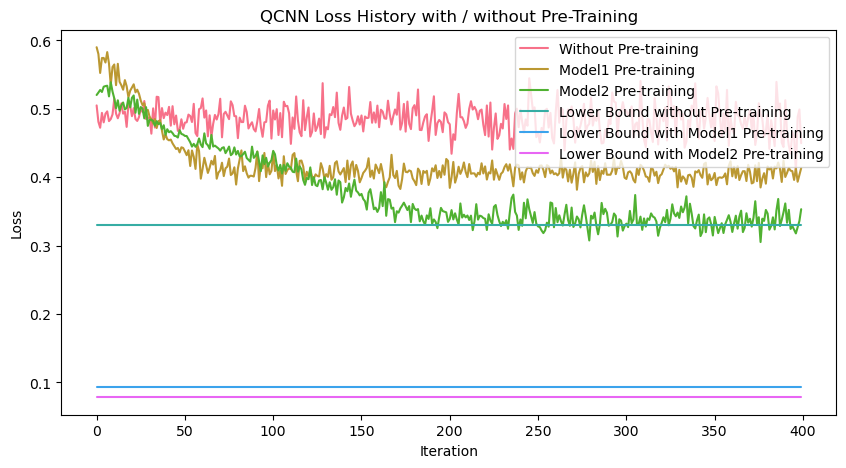

In [22]:


import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 6)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_not_trained)), loss_not_trained, label="Without Pre-training", c=clrs[0])
    ax.plot(range(len(loss_Noisy_Model1_Fidelity)), loss_Noisy_Model1_Fidelity, label="Model1 Pre-training", c=clrs[1])
    ax.plot(range(len(loss_Noisy_Model2_Fidelity)), loss_Noisy_Model2_Fidelity, label="Model2 Pre-training", c=clrs[2])

    ax.plot(range(400), np.ones(400) * LB_before_traindata, label="Lower Bound without Pre-training", c=clrs[3])
    ax.plot(range(400), np.ones(400) * LB_model1_traindata, label="Lower Bound with Model1 Pre-training", c=clrs[4])
    ax.plot(range(400), np.ones(400) * LB_model2_traindata, label="Lower Bound with Model2 Pre-training", c=clrs[5])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History with / without Pre-Training")
ax.legend()

In [23]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


predictions_Noisy_Model1_Fidelity = [QCNN_classifier(weights_Noisy_Model1_Fidelity, x, Trained='Noisy_Model1_Fidelity') for x in X_test]
predictions_Noisy_Model2_Fidelity = [QCNN_classifier(weights_Noisy_Model2_Fidelity, x, Trained='Noisy_Model2_Fidelity') for x in X_test]
predictions_not_trained = [QCNN_classifier(weights_not_trained, x, Trained=False) for x in X_test]

accuracy_Noisy_Model1_Fidelity = accuracy_test(predictions_Noisy_Model1_Fidelity, Y_test)
accuracy_Noisy_Model2_Fidelity = accuracy_test(predictions_Noisy_Model2_Fidelity, Y_test)
accuracy_not_trained = accuracy_test(predictions_not_trained, Y_test)

print(f" Accuracy after pre-training with Noisy_Model1_Fidelity: {accuracy_Noisy_Model1_Fidelity}")
print(f" Accuracy after pre-training with Noisy_Model2_Fidelity: {accuracy_Noisy_Model2_Fidelity}")
print(f" Accuracy without pre-training: {accuracy_not_trained}")

 Accuracy after pre-training with Noisy_Model1_Fidelity: 0.9640661938534278
 Accuracy after pre-training with Noisy_Model2_Fidelity: 0.9820330969267139
 Accuracy without pre-training: 0.566903073286052
